## Gibbs-mintavétel hierarchikus bayesi modellekben

Ezen az órán egy valószínűségi modellben fogunk következtetni MCMC algoritmussal (Gibbs-mintavétellel), amelyet a COVID-19 halálozási statisztikák vizsgálatára használunk fel. Adott időintervallumban bekövetkező események számának modellezésére rendszerint Poisson-eloszlást szoktunk használni. Feltesszük, hogy a $k_i$-vel jelölt heti halálozások ($i = 1, 2, \dots$) is ilyen eloszlást követnek. Feltesszük azt is, hogy a halálozást valójában két folyamat generálja:

- Az egyik a járvány berobbanása előtt (tehát a heti halálozások eleinte Poisson-eloszlásúak ismeretlen $\lambda_1$ paraméterrel),
- A másik a járvány berobbanása után (a heti halálozások ugyanúgy Poisson-eloszlásúak, de már egy másik, $\lambda_2$ paraméterrel).

Jelölje $N$ a hetek számát összesen, $n$ pedig azt a hetet, ahol a folyamat átvált egyikből a másikba, azaz a járvány berobbanását. A feladatunk, hogy $\lambda_1$, $\lambda_2$ és $n$ eloszlását megbecsüljük a megfigyelt $k_i$-k mellett. Bayesi következtetésnél priorokat teszünk a paraméterekre (ügyelve a kiszámíthatóságra, azaz a konjugált priorok használatára). Vegyük a következő valószínűségi modellt:

$$
\begin{array}{l}
p\left(n \mid \pi \right) &= Cat\left(n \mid \pi\right) &= \prod_j \pi_j^{one\_hot(n)_j},\\
p\left(\lambda_1 \mid \alpha_1, \beta_1 \right) &= Gamma\left(\lambda_1 \mid \alpha_1, \beta_1 \right) &= \frac{\beta_1^{\alpha_1}}{\Gamma(\alpha_1)} \lambda_1^{\alpha_1-1} e^{-\beta_1\lambda_1},\\
p\left(\lambda_2 \mid \alpha_2, \beta_2 \right) &= Gamma\left(\lambda_2 \mid \alpha_2, \beta_2 \right) &= \frac{\beta_2^{\alpha_2}}{\Gamma(\alpha_2)} \lambda_2^{\alpha_2-1} e^{-\beta_2\lambda_2}, \\
p\left(\mathbf{k} \mid \lambda_1, \lambda_2,n \right) &= \prod_i p\left(k_i \mid \lambda_1,\lambda_2,n \right),
\end{array}
$$
ahol
$$
p\left(k_i \mid \lambda_1,\lambda_2,n \right) = \begin{cases} Poisson \left( k_i \mid \lambda_1 \right) = \frac{\lambda_1^{k_i}}{k_i!} e^{-\lambda_1}, & \text{ha } i\le n,\\
Poisson \left( k_i \mid \lambda_2 \right) = \frac{\lambda_2^{k_i}}{k_i!} e^{-\lambda_2}, & \text{ha } i>n.
\end{cases}
$$

A Gibbs-mintavételhez szükségünk lesz a feltételes eloszlásokra (egy-egy változó feltételes eloszlása az összes többit rögzítve); a következő szakaszban ezeket számoljuk ki.

## Feltételes eloszlások

Először az együttes eloszlás az előbbiek szorzataként adódik:
\begin{align}
&p\left(n,\lambda_1,\lambda_2,\mathbf{k} \mid \alpha_1,\beta_1,\alpha_2,\beta_2,\pi\right)\\&= p\left(n \mid \pi \right) p\left(\lambda_1 \mid \alpha_1, \beta_1 \right) p\left(\lambda_2 \mid \alpha_2, \beta_2 \right) p\left(\mathbf{k} \mid \lambda_1, \lambda_2,n \right) \\
&=\prod_j \pi_j^{one\_hot(n)_j} \cdot \frac{\beta_1^{\alpha_1}}{\Gamma(\alpha_1)} \lambda_1^{\alpha_1-1} e^{-\beta_1\lambda_1} \cdot \frac{\beta_2^{\alpha_2}}{\Gamma(\alpha_2)} \lambda_2^{\alpha_2-1} e^{-\beta_2\lambda_2} \cdot \prod_{i=1}^n\frac{\lambda_1^{k_i}}{k_i!} e^{-\lambda_1} \cdot\prod_{i=n+1}^N\frac{\lambda_2^{k_i}}{k_i!} e^{-\lambda_2}
\end{align}

A feltételes eloszlásokhoz ebből gyűjtjük össze a kérdéses tagokat:
$$
\begin{array}{l}
p\left(\lambda_1 \mid n,\mathbf{k},\alpha_1,\beta_1\right) \propto \lambda_1^{\alpha_1-1 + \sum_{i=1}^n k_i} e^{-(\beta_1+n)\lambda_1} \propto Gamma \left(\lambda_1 \mid \alpha_1 + \sum_{i=1}^n k_i, \beta_1+n\right) \\
p\left(\lambda_2 \mid n,\mathbf{k},\alpha_2,\beta_2\right) \propto \lambda_2^{\alpha_2-1 + \sum_{i=n+1}^N k_i} e^{-(\beta_2+N-n)\lambda_2} \propto Gamma \left(\lambda_2 \mid \alpha_2 + \sum_{i=n+1}^N k_i, \beta_2+N-n\right)
\end{array}
$$

Az $n$-re vonatkozó feltételes eloszlás bonyolultabb, de a valószínűségeket szerencsére ki tudjuk számolni $n$ minden lehetséges értékére. Számoljuk ki például $n=5$-re:
$$
p\left(n=5 \mid \lambda_1,\lambda_2,\mathbf{k},\pi\right) = \pi_5 \cdot \prod_{i=1}^5\frac{\lambda_1^{k_i}}{k_i!} e^{-\lambda_1} \cdot\prod_{i=6}^N\frac{\lambda_2^{k_i}}{k_i!} e^{-\lambda_2},
$$
és ezt tetszőleges értékre elvégezhetjük.

## Gibbs-mintavétel

A feltételes eloszlások ismeretében könnyedén implementálhatjuk a Gibbs-mintavételt:

1. Inicializáljuk $n$-t, $\lambda_1$-t és $\lambda_2$-t (pl. a prior alapján).
2. Kiszámítjuk $\lambda_1$ feltételes eloszlását, majd ebből mintát véve frissítjük $\lambda_1$-t.
3. Kiszámítjuk $\lambda_2$ feltételes eloszlását, majd ebből mintát véve frissítjük $\lambda_2$-t.
4. Kiszámítjuk $n$ feltételes eloszlását, majd ebből mintát véve frissítjük $n$-t.
5. Ismétlés 2)-től.

Mindeközben folyamatosan gyűjtjük a mintákat, azaz a frissítés mellett a régi értékeket is eltároljuk. A változók eloszlását a gyűjtött mintákkal közelítjük (a gyakorlatban először egy ún. burn-in fázist csinálunk, hogy a Markov-lánc a keresett eloszlás "közelébe" kerüljön; a burn-in fázisban tehát még nem gyűjtjük a mintákat).


In [43]:
%pylab inline

from scipy.stats import poisson

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['poisson']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**1. feladat.** Generáljon egy toy adathalmazt a következő blokk futtatásával. A $\pi$ paramétert most az egyszerűség kedvéért nem használjuk, azaz uniform prior eloszlást teszünk fel $n$-re.

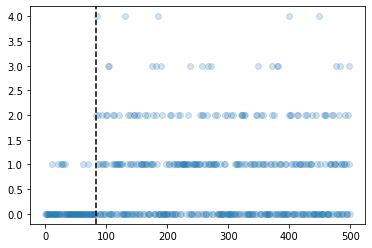

In [44]:
N = 500
a1,b1,a2,b2 = 1,5,3,5
l1_,l2_,n_  = np.random.gamma(a1,1/b1),np.random.gamma(a2,1/b2),int(ceil(rand()*N))
k = np.concatenate([np.random.poisson(l1_,n_),np.random.poisson(l2_,N-n_)])

scatter(range(N),k,alpha=0.2)
axvline(n_,ls='dashed',c='black')

**2. feladat.** Valósítsa meg a Gibbs-mintavételt (kb. 15 sorban megoldható).

- Ügyeljen a hatékonyságra, `for` ciklust csak legkívül, az iterációkhoz (burn-in, mintavétel) használjon.
- Külső csomagot ne használjon, ezalól kivétel a `numpy` és a `scipy` (amit fent importáltunk). Például `np.random.gamma` biztosan kell.
- Az összegek számításához érdemes használni az `np.cumsum` függvényt (ha előre megvan a kumulatív szumma, akkor a részösszegek már nagyon könnyen számíthatók).
- Ügyeljen a numerikus stabilitásra (például érdemes logaritmikusan számolni a `poisson.logpmf` függvénnyel).
- $n$ mintavételezéséhez használja az `np.random.choice` függvényt.

In [45]:
def it(i, l1, l2, n):
  for i in range(1, i):
    sk = np.cumsum(k)
    sn1 = sk[n[i-1]]
    sn2 = sk[sk.shape[0]-1] - sn1
    l1[i] = np.random.gamma(a1 + sn1, 1 / (b1 + n[i-1]))
    l2[i] = np.random.gamma(a2 + sn2, 1 / (b2 + N - n[i-1]))

    frw = np.cumsum(poisson.logpmf(k, l1[i]))
    rev = np.flip(np.cumsum(poisson.logpmf(np.flip(k), l2[i])))
    lp = frw + rev
    norm = exp(lp - lp.max())
    n[i] = np.random.choice(range(0, N),p=norm/norm.sum())
  return l1, l2, n

iters = 10000
burn_in = 1000

l1_b, l2_b, n_b = np.zeros(burn_in), np.zeros(burn_in), np.zeros(burn_in, dtype=int)
l1_b[0] = a1/b1
l2_b[0] = a2/b2
n_b[0] = N/2

l1_b_n, l2_b_n, n_b_n = it(burn_in, l1_b, l2_b, n_b) 
  
l1, l2, n = np.zeros(iters), np.zeros(iters), np.zeros(iters, dtype=int)
l1[0] = l1_b_n[burn_in - 1]
l2[0] = l2_b_n[burn_in - 1]
n[0] = n_b_n[burn_in - 1]

l1, l2, n = it(iters, l1, l2, n)


**3. feladat.** Ábrázolja a hisztogramon a gyűjtött mintákat! Hogyan viszonyulnak ezek a valódi $n$, $\lambda_1$ és $\lambda_2$ értékekhez? **Vizsgálja meg, hogy milyen valódi paraméterek esetén teljesít jól vagy gyengébben az algoritmus.**

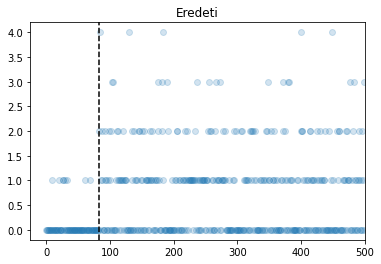

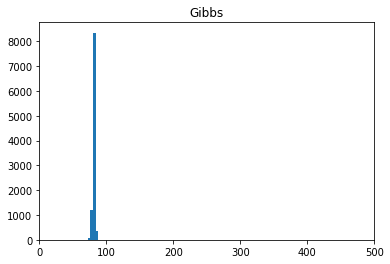

In [46]:
# Eredeti
plt.figure()
plt.scatter(range(N),k,alpha=0.2)
axvline(n_,ls='dashed',c='black')
plt.xlim(right=N)
plt.title("Eredeti")

# Hisztogram
plt.figure()
plt.hist(n, bins=range(0, N, 4))
plt.xlim(left=0, right=N)
plt.title("Gibbs")
plt.show()

Többszöri tesztre változó eredményeket kaptam: itt például:


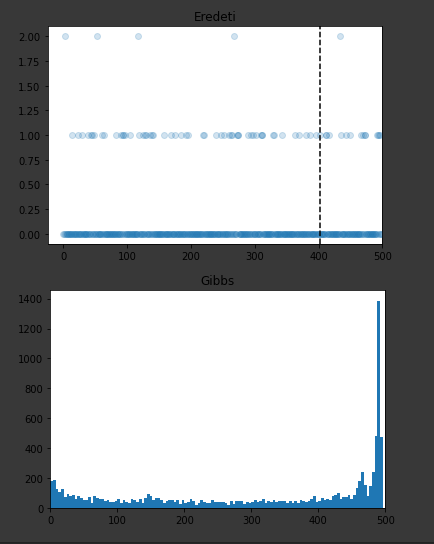

Kifejezetten pontatlannak mondható. Alapvetően azt figyeltem meg, hogy két, hasonlóbb eloszlásnál magasabb hibaaránnyal működik, míg eltérőek esetény hajszál pontos tud lenni.


**4. feladat.** Trace plot-nak nevezzük a gyűjtött minták ábrázolását az idő függvényében. Ez információt nyújt arról, hogy a Markov-lánc mennyire hatékonyan járja be a paraméterteret (mixing). Ábrázolja a trace plotot mindhárom változóra, vizsgálja meg a mixinget.

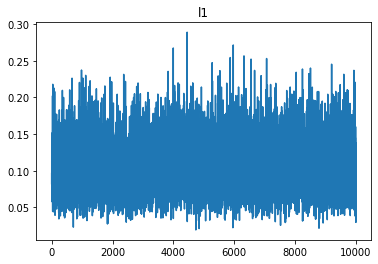

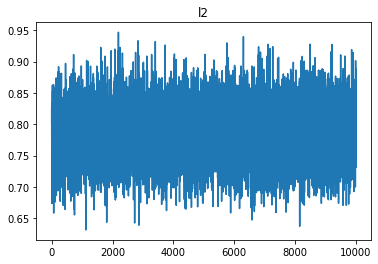

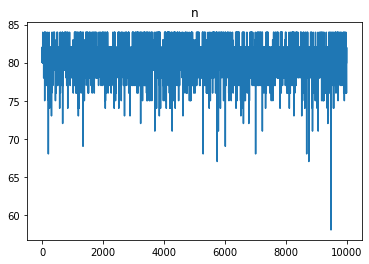

In [47]:
plt.figure()
plt.plot(range(iters), l1)
plt.title("l1")

plt.figure()
plt.plot(range(iters), l2)
plt.title("l2")

plt.figure()
plt.plot(range(iters), n)
plt.title("n")

plt.show()

Alapvetően merően eltérő, ugró értékekből csak pár van, relatíve korrekten közelítenek a változók - ez részben köszönhető a burn-in-nek, köszönhető - viszonylagosan jól járjuk be a paramétereket.

**5. feladat.** Töltse le a kurzus Teams oldaláról a `halalozas.tsv` nevű file-t, amely a magyarországi halálozási adatokat tartalmazza 2019-től kezdve mostanáig. Végezze el rá az előbbi elemzést, dokumentálja a tapasztalatokat.